## 한글 폰트 설치

- 참고: https://teddylee777.github.io/colab/colab-korean

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

## 데이터셋

In [2]:
from teddynote import dataset

dataset.download('지하철승하차인원')

======= 다운로드 시작 =======

data\지하철_승하차인원.csv


  0%|          | 0.00/31.1k [00:00<?, ?B/s]


======= 다운로드 완료 =======


- [서울교통공사_월별 승하차인원](https://www.data.go.kr/data/15044249/fileData.do)
- [지하철역 주소 정보](http://data.seoul.go.kr/dataList/OA-12035/S/1/datasetView.do)

## 모듈 import & 파일 로드

In [18]:
import os
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

DATA = 'data'

In [19]:
# 파일 로드
file1 = os.path.join(DATA, '지하철_승하차인원.csv')
df = pd.read_csv(file1, encoding='euc-kr')
df

,호선,역번호,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,1호선,150,서울역(1),3364130,3026680,3446064,3473124,3563150,3302692,3402309,3384029,3205334,3589014,3496294,3543766
1,1호선,151,시청(1),1562110,1275441,1581722,1635208,1666756,1527076,1586068,1592866,1463466,1875878,1691849,1744402
2,1호선,152,종각,2740119,2276059,2650404,2634617,2704398,2458042,2716809,2625393,2354321,2789296,2629753,2875434
3,1호선,153,종로3가(1),2143877,1823175,2106819,2039389,2154261,1989308,2092865,1987469,1843767,2129128,1995373,2133123
4,1호선,154,종로5가,1701378,1452300,1733436,1703251,1749096,1583541,1617625,1571120,1493315,1754767,1673923,1748656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,9호선,4134,송파나루,126242,112765,138597,146349,149438,138761,154548,153004,139389,156361,159925,173431
284,9호선,4135,한성백제,71767,61579,75888,82032,96069,81802,86838,86604,91050,101864,98105,97581
285,9호선,4136,올림픽공원(9),200886,167697,238828,244474,283858,282596,292005,284730,244540,291573,292314,313639
286,9호선,4137,둔촌오륜,29747,27600,38496,39962,40463,39044,40986,38286,40227,43596,44182,43115


## 역명에 대한 클린징

In [20]:
import re

# Regular Expression 적용하여 ()괄호를 제거 후 추출
pattern_string = r'.+(?=\()'
pattern = re.compile(pattern_string)

In [21]:
pattern.match('올림픽공원(9)').group().strip()

'올림픽공원'

In [22]:
def clean_station(x):
    # 코드입력
    location = pattern.match(x)
    if location:
        loc = location.group().strip()
    else:
        loc = x
    return loc   

In [23]:
# 코드입력
df['역명_clean'] = df['역명'].apply(clean_station)
df[['역명_clean', '역명']].head(10)

,역명_clean,역명
0,서울역,서울역(1)
1,시청,시청(1)
2,종각,종각
3,종로3가,종로3가(1)
4,종로5가,종로5가
5,동대문,동대문(1)
6,신설동,신설동(1)
7,제기동,제기동
8,청량리,청량리
9,동묘앞,동묘앞(1)


`역명` 컬럼을 제거한 뒤, `역명_clean`컬럼을 `역명`으로 변환합니다.

In [24]:
# 코드입력
df = df.drop('역명', axis=1)
df = df.rename({'역명_clean':'역명'}, axis=1)
df.head()

,호선,역번호,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,역명
0,1호선,150,3364130,3026680,3446064,3473124,3563150,3302692,3402309,3384029,3205334,3589014,3496294,3543766,서울역
1,1호선,151,1562110,1275441,1581722,1635208,1666756,1527076,1586068,1592866,1463466,1875878,1691849,1744402,시청
2,1호선,152,2740119,2276059,2650404,2634617,2704398,2458042,2716809,2625393,2354321,2789296,2629753,2875434,종각
3,1호선,153,2143877,1823175,2106819,2039389,2154261,1989308,2092865,1987469,1843767,2129128,1995373,2133123,종로3가
4,1호선,154,1701378,1452300,1733436,1703251,1749096,1583541,1617625,1571120,1493315,1754767,1673923,1748656,종로5가


## 중복 되는 역에 대한 승하차 인원 합계 환산

In [25]:
df.loc[df['역명'] == '서울역']

,호선,역번호,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,역명
0,1호선,150,3364130,3026680,3446064,3473124,3563150,3302692,3402309,3384029,3205334,3589014,3496294,3543766,서울역
110,4호선,426,1105093,973842,1167990,1164404,1174031,1091847,1138933,1121257,1056526,1201541,1181427,1204728,서울역


In [26]:
df.loc[df['역명'] == '고속터미널']

,호선,역번호,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,역명
79,3호선,329,3650330,3443565,3763343,3549653,3881177,3578839,3659723,3830191,3512161,3719899,3732376,3933493,고속터미널
232,7호선,2736,1200218,1091379,1203247,1187192,1245421,1153031,1185762,1190917,1143816,1258013,1231791,1236209,고속터미널


`역명`을 기준으로 승하차인원에 대한 합계를 구합니다.

In [27]:
# 코드입력
df_total = df.groupby('역명').sum().reset_index().drop('역번호', axis=1)
df_total

,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,가락시장,1172018,961948,1153158,1166383,1161625,1072459,1124263,1056539,1043442,1163322,1170635,1221485
1,가산디지털단지,2558564,2083546,2442252,2520173,2507799,2262116,2558788,2300971,2218934,2459146,2467699,2430534
2,강남,6731617,5537751,6234948,6070160,6247693,5876947,6809521,6363167,5458954,6073476,6027683,6361642
3,강남구청,980057,802269,977457,995296,1008723,928293,997659,931419,886769,1007349,1005622,998240
4,강동,1145633,972550,1186391,1193841,1222583,1140184,1233732,1166811,1118171,1253802,1231872,1244817
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,홍제,1131352,977157,1235738,1241081,1272282,1143038,1154822,1097604,1108654,1233937,1193338,1177045
247,화곡,1762766,1510610,1826195,1854362,1897859,1737139,1822525,1717743,1656990,1839997,1791497,1828432
248,화랑대,660606,560735,748303,757517,792196,689357,694126,651611,687711,770130,748711,718661
249,회현,1864182,1574625,2027233,2050713,2096872,1909038,1950431,1825184,1719782,2062291,1943588,1952633


**역번호**도 합계가 구해졌기 때문에, 역번호를 이전 데이터프레임으로부터 병합합니다.

In [28]:
df_merged = pd.merge(df_total, df.drop_duplicates('역명', keep='first')[['역명', '역번호']], how='left')
df_merged

,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,역번호
0,가락시장,1172018,961948,1153158,1166383,1161625,1072459,1124263,1056539,1043442,1163322,1170635,1221485,340
1,가산디지털단지,2558564,2083546,2442252,2520173,2507799,2262116,2558788,2300971,2218934,2459146,2467699,2430534,2748
2,강남,6731617,5537751,6234948,6070160,6247693,5876947,6809521,6363167,5458954,6073476,6027683,6361642,222
3,강남구청,980057,802269,977457,995296,1008723,928293,997659,931419,886769,1007349,1005622,998240,2732
4,강동,1145633,972550,1186391,1193841,1222583,1140184,1233732,1166811,1118171,1253802,1231872,1244817,2549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,홍제,1131352,977157,1235738,1241081,1272282,1143038,1154822,1097604,1108654,1233937,1193338,1177045,314
247,화곡,1762766,1510610,1826195,1854362,1897859,1737139,1822525,1717743,1656990,1839997,1791497,1828432,2518
248,화랑대,660606,560735,748303,757517,792196,689357,694126,651611,687711,770130,748711,718661,2647
249,회현,1864182,1574625,2027233,2050713,2096872,1909038,1950431,1825184,1719782,2062291,1943588,1952633,425


**고속터미널** 역에 대한 합계치 비교

In [29]:
df.loc[df['역명'] == '고속터미널']

,호선,역번호,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,역명
79,3호선,329,3650330,3443565,3763343,3549653,3881177,3578839,3659723,3830191,3512161,3719899,3732376,3933493,고속터미널
232,7호선,2736,1200218,1091379,1203247,1187192,1245421,1153031,1185762,1190917,1143816,1258013,1231791,1236209,고속터미널


In [30]:
df_merged.loc[df_merged['역명'] == '고속터미널']

,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,역번호
15,고속터미널,4850548,4534944,4966590,4736845,5126598,4731870,4845485,5021108,4655977,4977912,4964167,5169702,329


## `seoul_station_geocode.csv` 파일 로드

In [10]:
# 코드입력
address = pd.read_csv('seoul_station_geocode.csv')
# csv 파일이 없는 경우
# address = pd.read_csv('https://raw.githubusercontent.com/teddylee777/dip/main/assets/seoul_station_geocode.csv')
address.head()

,호선,역명,lat,lng,주소,역번호
0,1,서울역,37.564119,126.976808,서울특별시 중구 세종대로 지하 2,150
1,1,시청,37.565704,126.976862,서울특별시 중구 세종대로 지하 101,151
2,1,종각,37.570169,126.983099,서울특별시 종로구 종로 지하 55,152
3,1,종로3가,37.570371,126.991005,서울특별시 종로구 종로 지하 129,153
4,1,종로5가,37.559785,126.970986,서울특별시 종로구 종로 지하 216,154


In [31]:
# 코드입력
merged_data = pd.merge(df_merged, address[['주소', '역명', 'lat', 'lng']], on='역명', how='left')
merged_data.head()

,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,역번호,주소,lat,lng
0,가락시장,1172018,961948,1153158,1166383,1161625,1072459,1124263,1056539,1043442,1163322,1170635,1221485,340,서울특별시 송파구 송파대로 지하 257,37.492663,127.118544
1,가산디지털단지,2558564,2083546,2442252,2520173,2507799,2262116,2558788,2300971,2218934,2459146,2467699,2430534,2748,서울특별시 금천구 벚꽃로 309,37.482255,126.882183
2,강남,6731617,5537751,6234948,6070160,6247693,5876947,6809521,6363167,5458954,6073476,6027683,6361642,222,서울특별시 강남구 강남대로 지하 396,37.497786,127.027777
3,강남구청,980057,802269,977457,995296,1008723,928293,997659,931419,886769,1007349,1005622,998240,2732,서울특별시 강남구 학동로 지하346,37.517133,127.041299
4,강동,1145633,972550,1186391,1193841,1222583,1140184,1233732,1166811,1118171,1253802,1231872,1244817,2549,서울특별시 강동구 천호대로 지하1097,37.537595,127.125370


In [32]:
df_merged.shape, merged_data.shape

((251, 14), (251, 17))

병합된 데이터셋에 대한 결측치 확인

In [33]:
merged_data.isnull().sum()

역명     0
1월     0
2월     0
3월     0
4월     0
5월     0
6월     0
7월     0
8월     0
9월     0
10월    0
11월    0
12월    0
역번호    0
주소     0
lat    0
lng    0
dtype: int64

## 주소 데이터 분할

In [34]:
# 코드입력
merged_data['주소'].str.split()

0        [서울특별시, 송파구, 송파대로, 지하, 257]
1             [서울특별시, 금천구, 벚꽃로, 309]
2        [서울특별시, 강남구, 강남대로, 지하, 396]
3           [서울특별시, 강남구, 학동로, 지하346]
4         [서울특별시, 강동구, 천호대로, 지하1097]
                   ...              
246    [서울특별시, 서대문구, 통일로, 지하, 440-1]
247         [서울특별시, 강서구, 화곡로, 지하168]
248         [서울특별시, 노원구, 화랑로, 지하510]
249         [서울특별시, 중구, 퇴계로, 지하, 54]
250         [서울특별시, 용산구, 백범로, 지하287]
Name: 주소, Length: 251, dtype: object

**구**만 추출하기

In [35]:
# 코드입력
merged_data['주소'].str.split().str[1]

0       송파구
1       금천구
2       강남구
3       강남구
4       강동구
       ... 
246    서대문구
247     강서구
248     노원구
249      중구
250     용산구
Name: 주소, Length: 251, dtype: object

In [36]:
# 코드입력
merged_data['구'] = merged_data['주소'].str.split().str[1]
merged_data['구']

0       송파구
1       금천구
2       강남구
3       강남구
4       강동구
       ... 
246    서대문구
247     강서구
248     노원구
249      중구
250     용산구
Name: 구, Length: 251, dtype: object

In [37]:
merged_data.head()

,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,역번호,주소,lat,lng,구
0,가락시장,1172018,961948,1153158,1166383,1161625,1072459,1124263,1056539,1043442,1163322,1170635,1221485,340,서울특별시 송파구 송파대로 지하 257,37.492663,127.118544,송파구
1,가산디지털단지,2558564,2083546,2442252,2520173,2507799,2262116,2558788,2300971,2218934,2459146,2467699,2430534,2748,서울특별시 금천구 벚꽃로 309,37.482255,126.882183,금천구
2,강남,6731617,5537751,6234948,6070160,6247693,5876947,6809521,6363167,5458954,6073476,6027683,6361642,222,서울특별시 강남구 강남대로 지하 396,37.497786,127.027777,강남구
3,강남구청,980057,802269,977457,995296,1008723,928293,997659,931419,886769,1007349,1005622,998240,2732,서울특별시 강남구 학동로 지하346,37.517133,127.041299,강남구
4,강동,1145633,972550,1186391,1193841,1222583,1140184,1233732,1166811,1118171,1253802,1231872,1244817,2549,서울특별시 강동구 천호대로 지하1097,37.537595,127.125370,강동구


## folium을 활용한 지도 시각화

In [38]:
import folium

# 위도
latitude = 37.394946
# 경도
longitude = 127.111104

m = folium.Map(location=[latitude, longitude],
               zoom_start=17, 
               width=750, 
               height=500
              )
m

In [41]:
station_name = '시청'
geo = list(merged_data.loc[merged_data['역명'] == station_name, ['lat', 'lng']].iloc[0])
print(f'위도: {geo[0]}, 경도: {geo[1]}')

# folium 시각화
m = folium.Map(location=geo,
               zoom_start=17, 
               width=750, 
               height=500
              )

folium.Marker(geo,
              popup=station_name,
              tooltip=f'{station_name} 정보').add_to(m)
m

위도: 37.5657037, 경도: 126.9768616


타일을 `cartodbpositron`으로 변경합니다.

In [42]:
m = folium.Map(
    location=[37.559819, 126.963895],
    zoom_start=11, 
    tiles='cartodbpositron'
)
m

## 서울 행정구역 표기 및 시각화에 boundary 적용

In [43]:
# 서울 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)
seoul_geo

자치구별 1월의 승하차인원 합계량을 산출합니다.

In [44]:
# 코드입력
merged_data.groupby('구')['1월'].sum()

구
강남구     31986874
강동구      9048155
강북구      5068922
강서구      7773009
고양시        74540
관악구     10851160
광명시      3106352
광진구     13114539
구로구     12282568
금천구      2558564
노원구     11458963
도봉구      4324439
동대문구     5587312
동작구     13309604
마포구     20015277
부천시      3895473
부평구      1551686
서대문구     2826656
서초구     17082128
성남시      2678442
성동구      9481839
성북구      6871698
송파구     19002401
양천구      4549536
영등포구     8185652
용산구      5642065
은평구     10222817
의정부시       96454
종로구     21171875
중구      26309294
중랑구      5279966
Name: 1월, dtype: int64

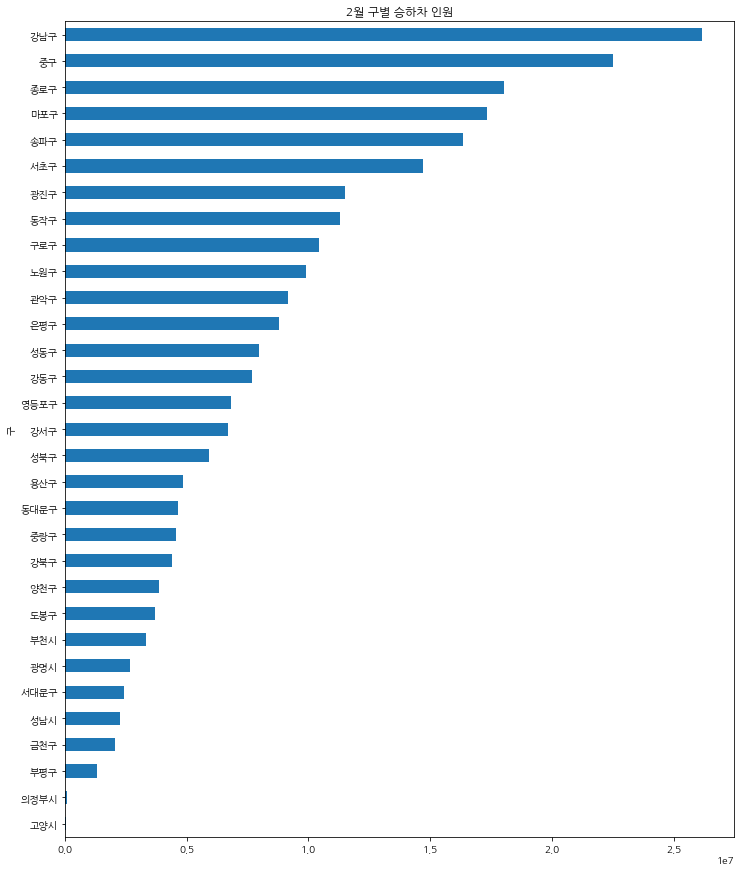

In [45]:
# 월 설정
N = 2

plt.figure(figsize=(12, 15))
merged_data.groupby('구')[f'{N}월'].sum().sort_values().plot(kind='barh')
plt.title(f'{N}월 구별 승하차 인원')
plt.show()

In [46]:
m = folium.Map(
    location=[37.559819, 126.963895],
    zoom_start=10, 
    tiles='cartodbpositron'
)

folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)

m.choropleth(geo_data=seoul_geo,
             data=merged_data.groupby('구')[f'{N}월'].sum(),
             fill_color='YlOrRd', # 색상 변경도 가능하다
             fill_opacity=0.9,
             line_opacity=0.2,
             key_on='properties.name',
             legend_name=f'{N}월 승하차 인원', 
            )
m

c:\users\teddy-pangyo\anaconda3\envs\py37\lib\site-packages\folium\folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## 통계 분석

In [47]:
stats = merged_data.drop(['주소', '역번호', 'lat', 'lng'], axis=1)
stats

,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,구
0,가락시장,1172018,961948,1153158,1166383,1161625,1072459,1124263,1056539,1043442,1163322,1170635,1221485,송파구
1,가산디지털단지,2558564,2083546,2442252,2520173,2507799,2262116,2558788,2300971,2218934,2459146,2467699,2430534,금천구
2,강남,6731617,5537751,6234948,6070160,6247693,5876947,6809521,6363167,5458954,6073476,6027683,6361642,강남구
3,강남구청,980057,802269,977457,995296,1008723,928293,997659,931419,886769,1007349,1005622,998240,강남구
4,강동,1145633,972550,1186391,1193841,1222583,1140184,1233732,1166811,1118171,1253802,1231872,1244817,강동구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,홍제,1131352,977157,1235738,1241081,1272282,1143038,1154822,1097604,1108654,1233937,1193338,1177045,서대문구
247,화곡,1762766,1510610,1826195,1854362,1897859,1737139,1822525,1717743,1656990,1839997,1791497,1828432,강서구
248,화랑대,660606,560735,748303,757517,792196,689357,694126,651611,687711,770130,748711,718661,노원구
249,회현,1864182,1574625,2027233,2050713,2096872,1909038,1950431,1825184,1719782,2062291,1943588,1952633,중구


In [48]:
stats.loc[stats['역명'] == '강남']

,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,구
2,강남,6731617,5537751,6234948,6070160,6247693,5876947,6809521,6363167,5458954,6073476,6027683,6361642,강남구


In [49]:
stats.loc[stats['역명'] == '강남'].iloc[:, 1:-1]

,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
2,6731617,5537751,6234948,6070160,6247693,5876947,6809521,6363167,5458954,6073476,6027683,6361642


[seaborn pointplot](https://seaborn.pydata.org/generated/seaborn.pointplot.html)

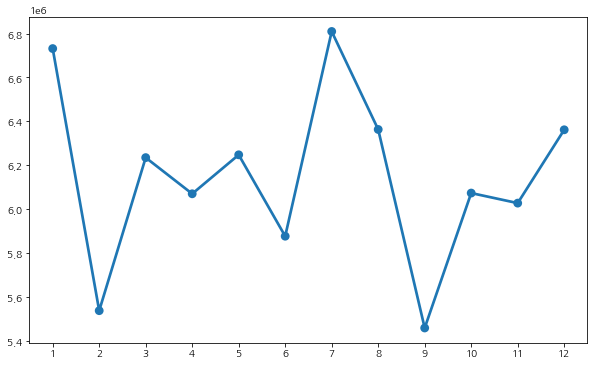

In [50]:
place = '강남'
plt.figure(figsize=(10, 6))
sns.pointplot(x = np.arange(1, 13), y=np.squeeze(stats.loc[stats['역명'] == place].iloc[:, 1:-1].values))
plt.show()

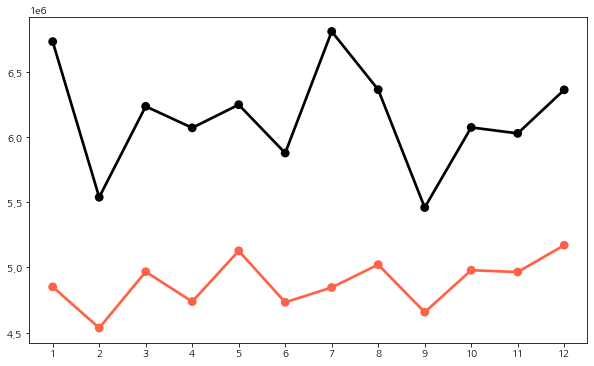

In [51]:
place1 = '강남'
place2 = '고속터미널'
plt.figure(figsize=(10, 6))
sns.pointplot(x = np.arange(1, 13), y=np.squeeze(stats.loc[stats['역명'] == place1].iloc[:, 1:-1].values), color='black')
sns.pointplot(x = np.arange(1, 13), y=np.squeeze(stats.loc[stats['역명'] == place2].iloc[:, 1:-1].values), color='tomato')
plt.show()

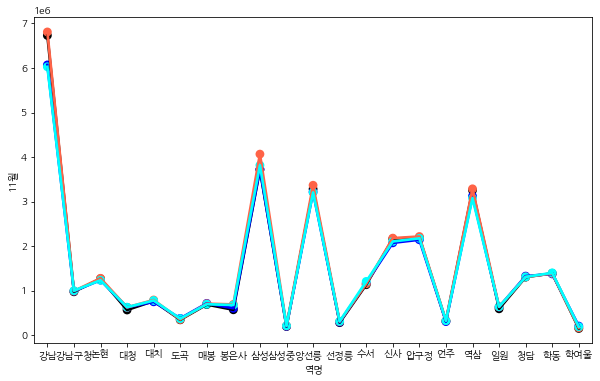

In [52]:
plt.figure(figsize=(10, 6))
sns.pointplot(x ='역명', y='1월', data=stats.loc[stats['구'] == '강남구'].iloc[:, :-1], color='black')
sns.pointplot(x ='역명', y='4월', data=stats.loc[stats['구'] == '강남구'].iloc[:, :-1], color='blue')
sns.pointplot(x ='역명', y='7월', data=stats.loc[stats['구'] == '강남구'].iloc[:, :-1], color='tomato')
sns.pointplot(x ='역명', y='11월', data=stats.loc[stats['구'] == '강남구'].iloc[:, :-1], color='cyan')
plt.show()

In [54]:
stats.loc[stats['구'] == '강남구'].iloc[:, :-1]

,역명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
2,강남,6731617,5537751,6234948,6070160,6247693,5876947,6809521,6363167,5458954,6073476,6027683,6361642
3,강남구청,980057,802269,977457,995296,1008723,928293,997659,931419,886769,1007349,1005622,998240
46,논현,1272566,1028376,1221938,1242691,1252265,1154789,1282475,1190215,1116400,1242568,1238770,1256900
52,대청,571540,489011,613628,629477,632760,581510,630489,578969,570768,622584,634588,638749
53,대치,771395,654803,781607,755131,793345,725059,795810,773877,733876,801589,784258,727270
55,도곡,351438,288849,362532,382806,377713,341816,357485,325844,327832,375562,377662,377118
78,매봉,693514,563078,685371,719930,708979,652900,712314,650121,629730,708523,700965,710419
100,봉은사,576278,491407,600983,609758,654489,593663,696649,655613,559641,654507,683500,771233
112,삼성,3719644,3046293,3643736,3729855,3893301,3487738,4068679,3711200,3219226,3716093,3818749,4177583
113,삼성중앙,200898,164486,198459,205198,204579,188419,214900,206399,191583,213799,218291,222865


강남구에 위치한 지하철역의 승하차인원을 heatmap으로 시각화합니다.

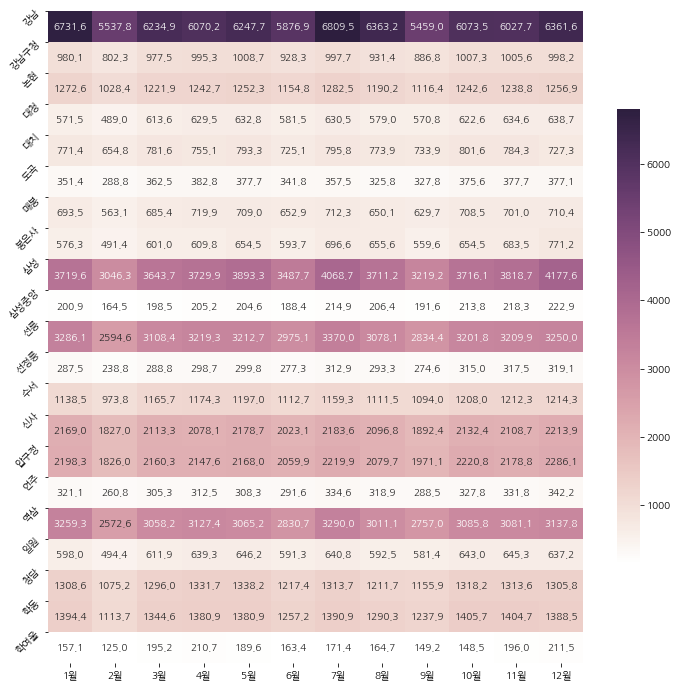

In [55]:
plt.figure(figsize=(12, 12))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(stats.loc[stats['구'] == '강남구'].iloc[:, 1:-1]/1000, annot=True, fmt='.1f', cmap=cmap, cbar_kws={"shrink": .7})
plt.yticks(np.arange(len(stats.loc[stats['구'] == '강남구'].iloc[:, 0].values)), stats.loc[stats['구'] == '강남구'].iloc[:, 0].values)
plt.yticks(rotation=45)
plt.show()

강남구에 위치한 역의 승하차 인원의 평균을 산출하여 `avg` 임시 변수에 대입합니다.

In [56]:
avg = stats.loc[stats['구'] == '강남구'].iloc[:, 1:-1].mean()
avg

1월     1.523184e+06
2월     1.246106e+06
3월     1.474686e+06
4월     1.488609e+06
5월     1.512308e+06
6월     1.396702e+06
7월     1.569198e+06
8월     1.458835e+06
9월     1.330056e+06
10월    1.496337e+06
11월    1.499513e+06
12월    1.549923e+06
dtype: float64

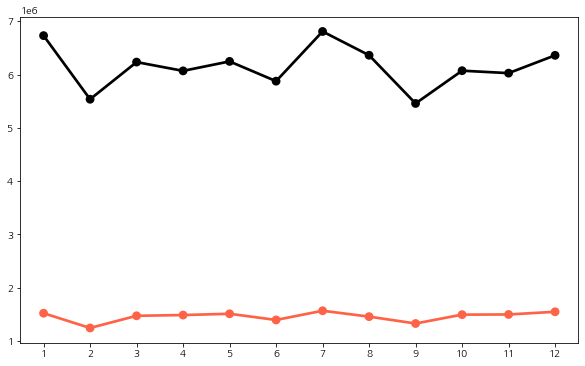

In [57]:
place1 = '강남'
plt.figure(figsize=(10, 6))
sns.pointplot(x = np.arange(1, 13), y=np.squeeze(stats.loc[stats['역명'] == place1].iloc[:, 1:-1].values), color='black')
sns.pointplot(x = np.arange(1, 13), y=np.squeeze(avg.values), color='tomato')
plt.show()

In [58]:
gangnam = stats.loc[stats['역명'] == place1].iloc[:, 1:-1].values
gangnam

array([[6731617, 5537751, 6234948, 6070160, 6247693, 5876947, 6809521,
        6363167, 5458954, 6073476, 6027683, 6361642]], dtype=int64)

강남역의 승하차 인원에 대한 정규화를 수행합니다.

In [59]:
gangnam_norm = (gangnam - gangnam.min()) / (gangnam.max() - gangnam.min())
gangnam_norm

array([[0.94231756, 0.05834364, 0.57456905, 0.45255511, 0.58400583,
        0.30949446, 1.        , 0.66950621, 0.        , 0.45501038,
        0.42110388, 0.66837706]])

In [60]:
avg = avg.values
avg

array([1523184.47619048, 1246105.95238095, 1474686.33333333,
       1488609.28571429, 1512308.04761905, 1396702.0952381 ,
       1569197.66666667, 1458835.04761905, 1330056.14285714,
       1496336.71428571, 1499512.76190476, 1549923.04761905])

강남구 평균 승하차 인원에 대한 정규화를 수행합니다.

In [61]:
avg_norm = (avg - avg.min()) / (avg.max() - avg.min())
avg_norm

array([0.85758474, 0.        , 0.70747831, 0.75057119, 0.82392115,
       0.46610958, 1.        , 0.65841706, 0.25983393, 0.77448833,
       0.7843185 , 0.9403432 ])

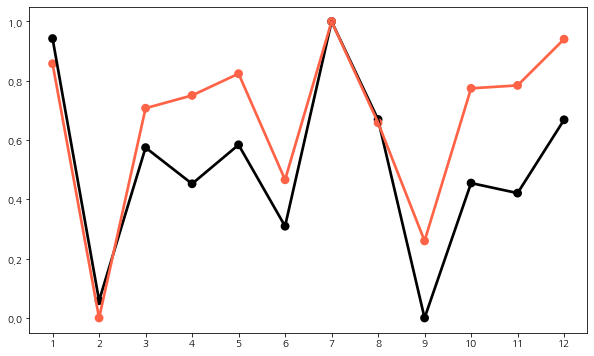

In [62]:
place1 = '강남'
plt.figure(figsize=(10, 6))
sns.pointplot(x = np.arange(1, 13), y=np.squeeze(gangnam_norm), color='black')
sns.pointplot(x = np.arange(1, 13), y=np.squeeze(avg_norm), color='tomato')
plt.show()